In [1]:
# enable autoreload
%load_ext autoreload
%autoreload 2
%matplotlib inline
%reload_ext autoreload

import os
os.environ['PROTOCOL_BUFFERS_PYTHON_IMPLEMENTATION']='python'

import scvi
scvi.settings.seed = 0
import scanpy as sc
import anndata as ad
import torch
import numpy as np
import pandas as pd
from datetime import datetime
from scipy.sparse import csr_matrix
torch.set_float32_matmul_precision('medium')
import warnings
warnings.simplefilter("ignore", UserWarning)

from dis2p.dis2pvi import Dis2pVI
from scfair.evaluate import *
# from scfair_reproducibility.evaluation.metrics import *

[2023-11-09 12:42:14,792] [INFO] [real_accelerator.py:133:get_accelerator] Setting ds_accelerator to cuda (auto detect)


Global seed set to 0
Global seed set to 0


# prepare data: Combo

In [4]:
# load dataset
adata = sc.read('/lustre/scratch126/cellgen/team205/ml19/Hesam2/scfair/combo_sciplex_prep_hvg_filtered.h5ad')
adata

AnnData object with n_obs × n_vars = 63378 × 5000
    obs: 'ncounts', 'well', 'plate', 'cell_line', 'replicate', 'time', 'dose_value', 'pathway1', 'pathway2', 'perturbation', 'target', 'pathway', 'dose_unit', 'celltype', 'disease', 'tissue_type', 'organism', 'perturbation_type', 'ngenes', 'percent_mito', 'percent_ribo', 'nperts', 'chembl-ID', 'condition', 'condition_ID', 'control', 'cell_type', 'smiles_rdkit', 'source', 'sample', 'Size_Factor', 'n.umi', 'RT_well', 'Drug1', 'Drug2', 'Well', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'leiden', 'split', 'condition_old', 'pert_type', 'batch', 'split_1ct_MEC', 'split_2ct_MEC', 'split_3ct_MEC', 'batch_cov', 'batch_cov_cond', 'log_dose', 'cov_drug_dose'
    var: 'ensembl_id-0', 'ncounts-0', 'ncells-0', 'symbol-0', 'symbol-1', 'id-1', 'n_cells-1', 'mt-1', 'n_cells_by_counts-1', 'mean_counts-1', 'pct_dropout_by_counts-1', 'total_counts-1', 'highly_variable-1', 'means-1', 'dispersions-1', 'dispersions_nor

In [5]:
# preprocess dataset
# sc.pp.filter_genes(adata, min_counts=3)
# adata.layers["counts"] = adata.X.copy()
# sc.pp.normalize_total(adata, target_sum=1e4)
# sc.pp.log1p(adata)
# adata.raw = adata
# sc.pp.highly_variable_genes(
#     adata,
#     n_top_genes=1200,
#     subset=True,
#     layer="counts",
#     flavor="seurat_v3",
# )

# specify name of dataset 
data_name = 'combo'

# specify attributes
cats = ['condition']

# create numerical index for each attr in cats
for i in range(len(cats)):
    values = list(set(adata.obs[cats[i]]))
    val_to_idx = {v: values.index(v) for v in values}
    idx_list = [val_to_idx[v] for v in adata.obs[cats[i]]]
    adata.obs[cats[i] + '_idx'] = pd.Categorical(idx_list)

# save adata
# adata.write_h5ad('data/heart_preprocessed1200.h5ad')

today = datetime.today().strftime('%Y-%m-%d')

In [6]:
adata

AnnData object with n_obs × n_vars = 63378 × 5000
    obs: 'ncounts', 'well', 'plate', 'cell_line', 'replicate', 'time', 'dose_value', 'pathway1', 'pathway2', 'perturbation', 'target', 'pathway', 'dose_unit', 'celltype', 'disease', 'tissue_type', 'organism', 'perturbation_type', 'ngenes', 'percent_mito', 'percent_ribo', 'nperts', 'chembl-ID', 'condition', 'condition_ID', 'control', 'cell_type', 'smiles_rdkit', 'source', 'sample', 'Size_Factor', 'n.umi', 'RT_well', 'Drug1', 'Drug2', 'Well', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'leiden', 'split', 'condition_old', 'pert_type', 'batch', 'split_1ct_MEC', 'split_2ct_MEC', 'split_3ct_MEC', 'batch_cov', 'batch_cov_cond', 'log_dose', 'cov_drug_dose', 'condition_idx'
    var: 'ensembl_id-0', 'ncounts-0', 'ncells-0', 'symbol-0', 'symbol-1', 'id-1', 'n_cells-1', 'mt-1', 'n_cells_by_counts-1', 'mean_counts-1', 'pct_dropout_by_counts-1', 'total_counts-1', 'highly_variable-1', 'means-1', 'dispersions-1',

# load/train model: Diffair(n_cf=1)

In [7]:
gb = adata.obs.groupby(['condition'])['condition_ID'].value_counts()
cond_dict = {}
for cond, condID in gb[gb.values!=0].index:
    cond_dict[cond] = condID

In [8]:
Dis2pVI.setup_anndata(
        adata,
        layer='counts',
        categorical_covariate_keys=cats,
        continuous_covariate_keys=[]
    )

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


In [9]:
model = Dis2pVI(adata, n_layers=1)

In [13]:
train = adata[adata.obs['split_1ct_MEC'].isin(['train', 'valid'])].copy()
ood = adata[adata.obs['split_1ct_MEC']=='ood'].copy()

In [14]:
DiffairVI.setup_anndata(
        train,
        layer='counts',
        categorical_covariate_keys=cats,
        continuous_covariate_keys=[]
    )
model = DiffairVI(train, n_layers=1)

In [16]:
# train params
epochs = 100
batch_size = 128
cf_weight = 1
beta = 1
clf_weight = 500
adv_clf_weight = 100
adv_period = 3
mode=(0,1,2,3,4)
n_cf = 1

# architecture params
n_layers=1

train_dict = {'max_epochs': epochs, 'batch_size': batch_size, 'cf_weight': cf_weight,
              'beta': beta, 'clf_weight': clf_weight, 'adv_clf_weight': adv_clf_weight,
              'adv_period': adv_period, 'mode': mode, 'n_cf': n_cf}

In [17]:
model.train(**train_dict)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [MIG-GPU-8391e223-da74-0458-e121-783edc78bf21/0/0]
/nfs/team205/ml19/miniconda3/envs/multimodal/lib/python3.8/site-packages/pytorch_lightning/core/optimizer.py:331: RuntimeWarning: The lr scheduler dict contains the key(s) ['monitor'], but the keys will be ignored. You need to call `lr_scheduler.step()` manually in manual optimization.
  rank_zero_warn(


Epoch 100/100: 100%|██████████| 100/100 [11:31<00:00,  7.25s/it, v_num=1, loss_validation=5.32e+3, x_0_validation=1.32e+3, x_1_validation=1.35e+3, rec_x_cf_validation=1.45e+3, z_1_validation=13.1, ce_validation=2.38, acc_validation=0.978, f1_validation=0.978, adv_ce_validation=3.29, adv_acc_validation=0.0266, adv_f1_validation=0.0266, loss_train=5.05e+3, x_0_train=1.32e+3, x_1_train=1.34e+3, rec_x_cf_train=1.45e+3, z_1_train=14.3, ce_train=2.38, acc_train=0.977, f1_train=0.977, adv_ce_train=2.48, adv_acc_train=0.035, adv_f1_train=0.035]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 100/100: 100%|██████████| 100/100 [11:31<00:00,  6.92s/it, v_num=1, loss_validation=5.32e+3, x_0_validation=1.32e+3, x_1_validation=1.35e+3, rec_x_cf_validation=1.45e+3, z_1_validation=13.1, ce_validation=2.38, acc_validation=0.978, f1_validation=0.978, adv_ce_validation=3.29, adv_acc_validation=0.0266, adv_f1_validation=0.0266, loss_train=5.05e+3, x_0_train=1.32e+3, x_1_train=1.34e+3, rec_x_cf_train=1.45e+3, z_1_train=14.3, ce_train=2.38, acc_train=0.977, f1_train=0.977, adv_ce_train=2.48, adv_acc_train=0.035, adv_f1_train=0.035]


In [18]:
module_name = 'scDiffair'
pre_path = f'models/{module_name}'
if not os.path.exists(pre_path):
    os.makedirs(pre_path)

# specify a name for your model
model_name =  f'{today},{module_name},{data_name},' + f'n_layers={n_layers},' + ','.join(k + '=' + str(v) for k, v in train_dict.items())

model.save(f"{pre_path}/{model_name}")

In [16]:
# train params
epochs = 400
batch_size = 128
cf_weight = 1
beta = 1
clf_weight = 500
adv_clf_weight = 100
adv_period = 3
mode=(0,1,2,3,4)
n_cf = 1

# architecture params
n_layers=1

train_dict = {'max_epochs': epochs, 'batch_size': batch_size, 'cf_weight': cf_weight,
              'beta': beta, 'clf_weight': clf_weight, 'adv_clf_weight': adv_clf_weight,
              'adv_period': adv_period, 'mode': mode, 'n_cf': n_cf}

module_name = 'scDiffair'
pre_path = f'models/{module_name}'
if not os.path.exists(pre_path):
    os.makedirs(pre_path)

# specify a name for your model
model_name =  f'{today},{module_name},{data_name},' + f'n_layers={n_layers},' + ','.join(k + '=' + str(v) for k, v in train_dict.items())

# load model (if trained before)
try:
    model = DiffairVI.load(f"{pre_path}/{model_name}", adata=train)

# trains the model (if not trained before) and save it into: pre_path + model_name
except:

    DiffairVI.setup_anndata(
        train,
        layer='counts',
        categorical_covariate_keys=cats,
        continuous_covariate_keys=[]
    )
    model = DiffairVI(train, n_layers=n_layers)
    model.train(**train_dict)
    model.save(f"{pre_path}/{model_name}")

INFO     No backup URL provided for missing file                                                                   
         models/scDiffair/2023-09-27,scDiffair,combo,n_layers=1,max_epochs=400,batch_size=128,cf_weight=1,beta=1,cl
         f_weight=500,adv_clf_weight=100,adv_period=3,mode=(0, 1, 2, 3, 4),n_cf=1/model.pt                         


100%|██████████| 55169/55169 [00:00<00:00, 78109.44it/s]

INFO     Generating sequential column names                                                                        



GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [MIG-GPU-6c388953-37bc-1254-e112-e32edee636f2/0/0]
/nfs/team205/ml19/miniconda3/envs/multimodal/lib/python3.8/site-packages/pytorch_lightning/core/optimizer.py:331: RuntimeWarning: The lr scheduler dict contains the key(s) ['monitor'], but the keys will be ignored. You need to call `lr_scheduler.step()` manually in manual optimization.
  rank_zero_warn(


Epoch 2/400:   0%|          | 1/400 [00:09<1:00:53,  9.16s/it, v_num=1, loss_validation=5.76e+3, x_0_validation=1.34e+3, x_1_validation=1.37e+3, rec_x_cf_validation=1.52e+3, z_1_validation=51.9, ce_validation=3.08, acc_validation=0.291, f1_validation=0.291, adv_ce_validation=3.25, adv_acc_validation=0.131, adv_f1_validation=0.131, loss_train=5.65e+3, x_0_train=1.4e+3, x_1_train=1.41e+3, rec_x_cf_train=1.59e+3, z_1_train=34.6, ce_train=3.16, acc_train=0.205, f1_train=0.205, adv_ce_train=3.27, adv_acc_train=0.102, adv_f1_train=0.102]

# load/train model: Diffair(n_cf=5)

In [8]:
# train params
epochs = 400
batch_size = 128
cf_weight = 1
beta = 1
clf_weight = 50
adv_clf_weight = 10
adv_period = 1
mode=(0,1,2,3,4)
n_cf = 5

# architecture params
n_layers=1

train_dict = {'max_epochs': epochs, 'batch_size': batch_size, 'cf_weight': cf_weight,
              'beta': beta, 'clf_weight': clf_weight, 'adv_clf_weight': adv_clf_weight,
              'adv_period': adv_period, 'mode': mode, 'n_cf': n_cf}

module_name = 'scDiffair'
pre_path = f'models/{module_name}'
if not os.path.exists(pre_path):
    os.makedirs(pre_path)

# specify a name for your model
model_name =  f'{today},{module_name},{data_name},' + f'n_layers={n_layers},' + ','.join(k + '=' + str(v) for k, v in train_dict.items())

# load model (if trained before)
try:
    model = DiffairVI.load(f"{pre_path}/{model_name}", adata=adata)

# trains the model (if not trained before) and save it into: pre_path + model_name
except:

    DiffairVI.setup_anndata(
        adata,
        layer='counts',
        categorical_covariate_keys=cats,
        continuous_covariate_keys=[]
    )
    model = DiffairVI(adata, n_layers=n_layers)
    model.train(**train_dict)
    model.save(f"{pre_path}/{model_name}")

INFO     No backup URL provided for missing file                                                                   
         models/scDiffair/2023-09-15,scDiffair,HeartAtlas,n_layers=1,max_epochs=400,batch_size=128,cf_weight=1,beta
         =1,clf_weight=50,adv_clf_weight=10,adv_period=1,mode=(0, 1, 2, 3, 4),n_cf=5/model.pt                      


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [MIG-GPU-8391e223-da74-0458-e121-783edc78bf21/0/0]
/lustre/scratch126/cellgen/team205/ks32/conda/lib/python3.10/site-packages/lightning/pytorch/core/optimizer.py:321: RuntimeWarning: The lr scheduler dict contains the key(s) ['monitor'], but the keys will be ignored. You need to call `lr_scheduler.step()` manually in manual optimization.
  rank_zero_warn(


Epoch 113/400:  28%|██▊       | 113/400 [23:13<58:58, 12.33s/it, v_num=1, loss_validation=2.18e+3, x_0_validation=293, x_1_validation=297, x_2_validation=299, x_3_validation=297, x_4_validation=298, rec_x_cf_validation=497, z_1_validation=14.6, z_2_validation=12.9, z_3_validation=15.3, z_4_validation=14, ce_validation=0.916, acc_validation=0.995, f1_validation=0.995, adv_ce_validation=1.31, adv_acc_validation=0.6, adv_f1_validation=0.6, loss_train=2.01e+3, x_0_train=273, x_1_train=280, x_2_train=279, x_3_train=279, x_4_train=280, rec_x_cf_train=459, z_1_train=13.1, z_2_train=12.9, z_3_train=13.2, z_4_train=12.5, ce_train=0.916, acc_train=0.995, f1_train=0.995, adv_ce_train=0.961, adv_acc_train=0.567, adv_f1_train=0.567]      
Monitored metric loss_validation did not improve in the last 45 records. Best score: 2155.715. Signaling Trainer to stop.


# get latent space

In [25]:
# load model
pre_path = f'models/scDiffair'
model_name = '2023-11-09,scDiffair,combo,n_layers=1,max_epochs=100,batch_size=128,cf_weight=1,beta=1,clf_weight=500,adv_clf_weight=100,adv_period=3,mode=(0, 1, 2, 3, 4),n_cf=1'
model = DiffairVI.load(f"{pre_path}/{model_name}", adata=train)

# Z_0
train.obsm[f'Diffair_Z_0'] = model.get_latent_representation(adata=train, nullify_cat_covs_indices=[s for s in range(len(cats))], nullify_shared=False)

for i in range(len(cats)):
    null_idx = [s for s in range(len(cats)) if s != i]
    # Z_i
    train.obsm[f'Diffair_Z_{i+1}'] = model.get_latent_representation(adata=train, nullify_cat_covs_indices=null_idx, nullify_shared=True)
    # Z_{-i}
    train.obsm[f'Diffair_Z_not_{i+1}'] = model.get_latent_representation(adata=train, nullify_cat_covs_indices=[i], nullify_shared=False)

INFO     File                                                                                                      
         models/scDiffair/2023-11-09,scDiffair,combo,n_layers=1,max_epochs=100,batch_size=128,cf_weight=1,beta=1,cl
         f_weight=500,adv_clf_weight=100,adv_period=3,mode=(0, 1, 2, 3, 4),n_cf=1/model.pt already downloaded      


# plot UMAP latent

---UMAP for Diffair_Z_0---


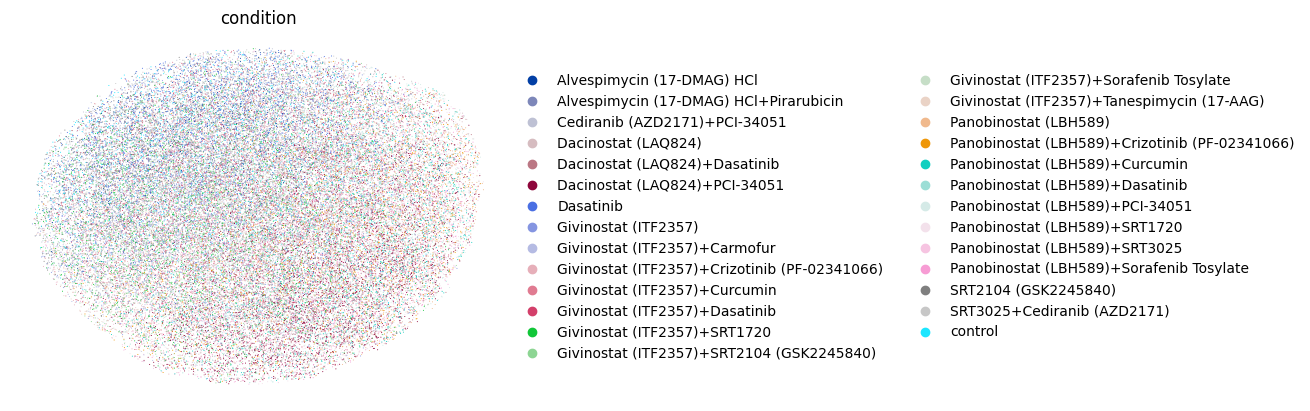

---UMAP for Diffair_Z_1---


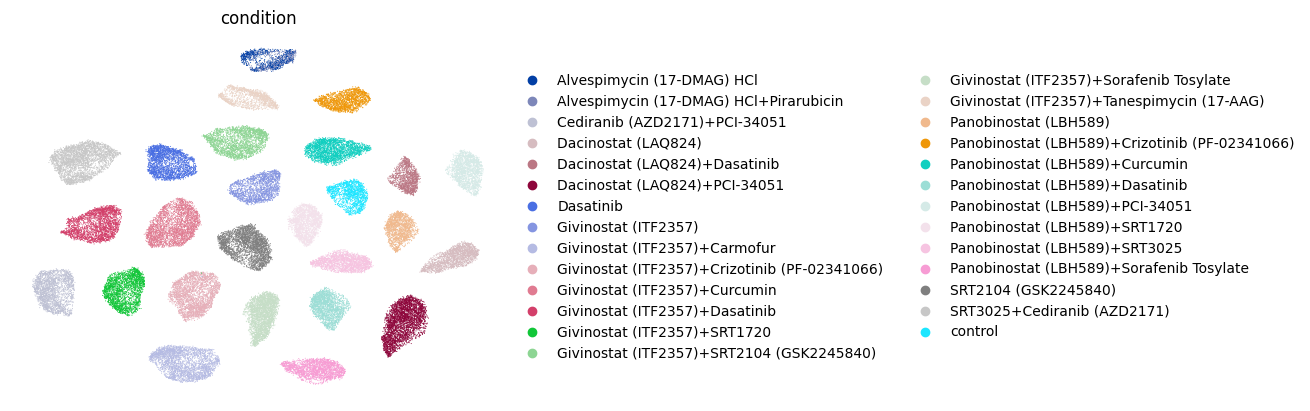

In [28]:
for i in range(len(cats) + 1):  # loop over all Z_i

    latent_name = f'Diffair_Z_{i}'

    print(f"---UMAP for {latent_name}---")

    sc.pp.neighbors(train, use_rep=f"{latent_name}")
    sc.tl.umap(train)

    sc.pl.umap(
        train,
        color=cats,
        ncols=len(cats),
        frameon=False,
    )

# Disentanglement/Fainess metrics

In [29]:
module_name = 'Diffair'
# average will be at the end eg:
# concatCAG = acc_gap_concat[-1]
# maxCAG = acc_gap_max[-1]

In [28]:
# MIG, MIPG
MI, MI_not_max, MI_not, MI_dif_max, MI_dif, maxMIG, concatMIG = Mixed_KSG_MI_metrics(adata, cats, module_name)

Method: Diffair
Mixed_KSG Mutual Information metrics
MI(Z_1 ; S_1) = 1.7291,  MI((Z - Z_1) ; S_1) = 0.7132, max MI((Z_j!=1) ; S_1) = 0.7703
MI(Z_2 ; S_2) = 1.2435,  MI((Z - Z_2) ; S_2) = 0.2634, max MI((Z_j!=2) ; S_2) = 0.5473
MI(Z_3 ; S_3) = 0.6716,  MI((Z - Z_3) ; S_3) = 0.0759, max MI((Z_j!=3) ; S_3) = 0.1318
MI(Z_4 ; S_4) = 1.7191,  MI((Z - Z_4) ; S_4) = 0.2755, max MI((Z_j!=4) ; S_4) = 0.3431
maxMIG = 0.6571, concatMIG = 0.7509


In [27]:
# DP, EO
create_cats_idx(adata, ['NRP'])
y_name = 'NRP_idx'
acc, DP_diff, EO_diff = fair_clf_metrics(adata, cats, y_name, module_name)

Method: Diffair
fairness metrics wrt Si for XGBoost classifier NRP_idx_bin | (Z - Zi)
i=1: accuracy = 0.9711, DP_diff = 0.0000, EO_diff = 0.0000
i=2: accuracy = 0.8869, DP_diff = 0.4000, EO_diff = 0.6000
i=3: accuracy = 0.9023, DP_diff = 0.0000, EO_diff = 0.0000
i=4: accuracy = 0.9702, DP_diff = 0.0000, EO_diff = 0.0000
average: accuracy = 0.9326, DP_diff = 0.1000, EO_diff = 0.1500


In [24]:
# classifier Si
acc, acc_not_concat, acc_not_max, acc_gap_concat, acc_gap_max = clf_S_Z_metrics(adata, cats, module_name)

Method: Diffair
XGBoost classifier for Si
acc(S_1 | Z_1) = 0.9973, acc(S_1 | Z - Z_1) = 0.7501, max acc(S_1 | Z_j!=1) = 0.5606
acc(S_2 | Z_2) = 0.9989, acc(S_2 | Z - Z_2) = 0.7738, max acc(S_2 | Z_j!=2) = 0.6729
acc(S_3 | Z_3) = 0.9988, acc(S_3 | Z - Z_3) = 0.7269, max acc(S_3 | Z_j!=3) = 0.6448
acc(S_4 | Z_4) = 0.9974, acc(S_4 | Z - Z_4) = 0.4624, max acc(S_4 | Z_j!=4) = 0.3334
concatCAG = 0.3198194761911338
maxCAG = 0.4451614952172797


# save Disentanglement/Fainess metrics in csv file

In [30]:
# convert results to dataframes
df_MI = pd.DataFrame(
      [MI, MI_not_max, MI_not, MI_dif_max, MI_dif]
)

df_fairness = pd.DataFrame(
      [acc, DP_diff, EO_diff]
)

df_acc = pd.DataFrame(
      [acc, acc_not_concat, acc_not_max, acc_gap_concat, acc_gap_max]
)

# create output folder and save csv
metrics_dir = f'metrics/{module_name}/'
os.makedirs(metrics_dir, exist_ok=True)  
df_acc.to_csv(metrics_dir+model_name+',acc_clf.csv', index=True)
df_fairness.to_csv(metrics_dir+model_name+',acc_adv_clf.csv', index=True) 
df_MI.to_csv(metrics_dir+model_name+',fairness_metrics.csv', index=True)


# OOD prediction

In [ ]:
# OOD params
cov_idx = 0
other_covs_values = ('HDAC inhibitor')
cov_value = 'control'
cov_value_cf = 'Givinostat (ITF2357)+Cediranib (AZD2171)'

# train params
epochs = 400
batch_size = 128
cf_weight = 1
beta = 1
clf_weight = 50
adv_clf_weight = 10
adv_period = 1
mode=(0,1,2,3,4)
n_cf = 1
n_layers = 1
train_dict = {'max_epochs': epochs, 'batch_size': batch_size, 'cf_weight': cf_weight,
              'beta': beta, 'clf_weight': clf_weight, 'adv_clf_weight': adv_clf_weight,
              'adv_period': adv_period, 'mode': mode, 'n_cf': n_cf}

module_name = 'scDiffair'
pre_path = f'models/{module_name}'
if not os.path.exists(pre_path):
    os.makedirs(pre_path)
    
new_model_name = 'OOD,' + f'{today},{module_name},{data_name},' + f'n_layers={n_layers},' + ','.join(k + '=' + str(v) for k, v in train_dict.items())

true_x_counts_mean, true_x_counts_variance, px_cf_mean_pred, px_cf_variance_pred = ood_for_given_covs(
        adata=adata,
        cats=cats,
        vi_cls=DiffairVI,
        model_name=new_model_name,
        pre_path=pre_path,
        cov_idx=cov_idx,
        cov_value=cov_value,
        cov_value_cf=cov_value_cf,
        other_covs_values=other_covs_values,
        remove_all_samples_with_other_covs_values=True,
        n_top_deg=20,
        **train_dict,
)

In [10]:
true_x_counts_mean_np = true_x_counts_mean.detach().numpy()
true_x_counts_variance_np = true_x_counts_variance.detach().numpy()
px_cf_mean_pred_np = px_cf_mean_pred.detach().numpy()
px_cf_variance_pred_np = px_cf_variance_pred.detach().numpy()

In [21]:
# OOD params
cov_idx = 2
other_covs_values = ('Ventricular_Cardiomyocyte', 'Sanger-Nuclei', 'RV')
cov_value = 'Male'
cov_value_cf = 'Female'

# train params
epochs = 400
batch_size = 128
cf_weight = 1
beta = 1
clf_weight = 50
adv_clf_weight = 10
adv_period = 1
mode=(0,1,2,3,4)
n_cf = 1
train_dict = {'max_epochs': epochs, 'batch_size': batch_size, 'cf_weight': cf_weight,
              'beta': beta, 'clf_weight': clf_weight, 'adv_clf_weight': adv_clf_weight,
              'adv_period': adv_period, 'mode': mode, 'n_cf': n_cf}

new_model_name = model_name+',OOD'

true_x_counts_mean, true_x_counts_variance, px_cf_mean_pred, px_cf_variance_pred = ood_for_given_covs(
        adata=adata,
        cats=cats,
        vi_cls=DiffairVI,
        model_name=new_model_name,
        pre_path=pre_path,
        cov_idx=cov_idx,
        cov_value=cov_value,
        cov_value_cf=cov_value_cf,
        other_covs_values=other_covs_values,
        remove_all_samples_with_other_covs_values=True,
        n_top_deg=20,
        **train_dict,
)

INFO     No backup URL provided for missing file                                                                   
         models/scDiffair/2023-09-15,scDiffair,HeartAtlas,n_layers=1,max_epochs=400,batch_size=128,cf_weight=1,beta
         =1,clf_weight=50,adv_clf_weight=10,adv_period=1,mode=(0, 1, 2, 3, 4),n_cf=1,OOD/model.pt                  


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [MIG-GPU-8391e223-da74-0458-e121-783edc78bf21/0/0]
/lustre/scratch126/cellgen/team205/ks32/conda/lib/python3.10/site-packages/lightning/pytorch/core/optimizer.py:321: RuntimeWarning: The lr scheduler dict contains the key(s) ['monitor'], but the keys will be ignored. You need to call `lr_scheduler.step()` manually in manual optimization.
  rank_zero_warn(


Epoch 112/400:  28%|██▊       | 112/400 [15:31<39:56,  8.32s/it, v_num=1, loss_validation=2.12e+3, x_0_validation=285, x_1_validation=289, x_2_validation=290, x_3_validation=288, x_4_validation=290, rec_x_cf_validation=476, z_1_validation=13.2, z_2_validation=12, z_3_validation=13.5, z_4_validation=12.9, ce_validation=0.927, acc_validation=0.984, f1_validation=0.984, adv_ce_validation=1.31, adv_acc_validation=0.6, adv_f1_validation=0.6, loss_train=2.06e+3, x_0_train=277, x_1_train=287, x_2_train=286, x_3_train=285, x_4_train=287, rec_x_cf_train=471, z_1_train=13.3, z_2_train=12.9, z_3_train=13.3, z_4_train=12.6, ce_train=0.928, acc_train=0.983, f1_train=0.983, adv_ce_train=0.96, adv_acc_train=0.572, adv_f1_train=0.572]       
Monitored metric loss_validation did not improve in the last 45 records. Best score: 2076.956. Signaling Trainer to stop.
INFO     AnnData object appears to be a copy. Attempting to transfer setup.                                        
Counterfactual prediction 

# save OOD prediction in csv file

In [13]:
# convert results to dataframes
df_ood = pd.DataFrame(
      [true_x_counts_mean_np, true_x_counts_variance_np, px_cf_mean_pred_np, px_cf_variance_pred_np]
)

# create output folder and save csv
metrics_dir = f'metrics/{module_name}'
os.makedirs(metrics_dir, exist_ok=True)  
df_ood.to_csv(metrics_dir+'/'+new_model_name+',ood_pred.csv')

# OOD R2 metrics

In [15]:
# load OOD prediction
metrics_dir = f'metrics/{module_name}'
df_ood_new = pd.read_csv(metrics_dir+'/'+new_model_name+',ood_pred.csv')
true_x_counts_m, true_x_counts_v, px_cf_m_pred, px_cf_v_pred = tuple(row[1:] for _, row in df_ood_new.iterrows())

In [20]:
n_top_deg = 20
cov_name = cats[cov_idx]

true_x_counts_stat = true_x_counts_m
px_cf_stat_pred = px_cf_m_pred

adata.var['name'] = adata.var.index
sc.tl.rank_genes_groups(adata, cov_name, method='wilcoxon', key_added="wilcoxon")
ranked_genes = sc.get.rank_genes_groups_df(adata, group=cov_value_cf, key='wilcoxon', gene_symbols='name')
ranked_genes_names = ranked_genes[ranked_genes['name'].notnull()]['name']
deg_names = ranked_genes_names[:n_top_deg]
deg_idx = [i for i, _ in enumerate(adata.var['name']) if adata.var['name'][i] in list(deg_names)]

r2 = r2_score(true_x_counts_stat, px_cf_stat_pred)
r2_log = r2_score(np.log1p(true_x_counts_stat), np.log1p(px_cf_stat_pred))
r2_deg = r2_score(true_x_counts_stat[deg_idx], px_cf_stat_pred[deg_idx])
r2_log_deg = r2_score(np.log1p(true_x_counts_stat[deg_idx]), np.log1p(px_cf_stat_pred[deg_idx]))

print('All Genes')
print(f'R2 = {r2:.4f}')
print(f'R2 log = {r2_log:.4f}')
print(f'DE Genes (n_top={n_top_deg})')
print(f'R2 = {r2_deg:.4f}')
print(f'R2 log = {r2_log_deg:.4f}')

All Genes
R2 = 0.8905
R2 log = 0.8904
DE Genes (n_top=20)
R2 = 0.9209
R2 log = 0.9330


In [ ]:
n_top_deg = 20
cov_name = cats[cov_idx]

true_x_counts_stat = true_x_counts_v
px_cf_stat_pred = px_cf_v_pred

adata.var['name'] = adata.var.index
sc.tl.rank_genes_groups(adata, cov_name, method='wilcoxon', key_added="wilcoxon")
ranked_genes = sc.get.rank_genes_groups_df(adata, group=cov_value_cf, key='wilcoxon', gene_symbols='name')
ranked_genes_names = ranked_genes[ranked_genes['name'].notnull()]['name']
deg_names = ranked_genes_names[:n_top_deg]
deg_idx = [i for i, _ in enumerate(adata.var['name']) if adata.var['name'][i] in list(deg_names)]

r2 = r2_score(true_x_counts_stat, px_cf_stat_pred)
r2_log = r2_score(np.log1p(true_x_counts_stat), np.log1p(px_cf_stat_pred))
r2_deg = r2_score(true_x_counts_stat[deg_idx], px_cf_stat_pred[deg_idx])
r2_log_deg = r2_score(np.log1p(true_x_counts_stat[deg_idx]), np.log1p(px_cf_stat_pred[deg_idx]))

print('All Genes')
print(f'R2 = {r2:.4f}')
print(f'R2 log = {r2_log:.4f}')
print(f'DE Genes (n_top={n_top_deg})')
print(f'R2 = {r2_deg:.4f}')
print(f'R2 log = {r2_log_deg:.4f}')

All Genes
R2 = 0.6740
R2 log = 0.6844
DE Genes (n_top=20)
R2 = 0.3960
R2 log = 0.3771


#  RUN this ##############

In [34]:
source = train[train.obs['condition']=='control'].copy()

In [35]:
cov_idx = 0

In [47]:
for cov_value_cf in ood.obs['condition'].unique():
    px_cf_mean_pred, px_cf_variance_pred = model.predict_given_covs(adata=source, cats=cats, cov_idx=cov_idx,
                                                                cov_value_cf=cov_value_cf)
    px_cf_mean_pred, px_cf_variance_pred = px_cf_mean_pred.to('cpu'), px_cf_variance_pred.to('cpu')
    true_x_count = torch.tensor(ood.layers["counts"][:, :5000])
    true_x_counts_mean = torch.mean(true_x_count, dim=0)
    true_x_counts_variance = torch.sub(true_x_count, true_x_counts_mean)
    true_x_counts_variance = torch.pow(true_x_counts_variance, 2)
    true_x_counts_variance = torch.mean(true_x_counts_variance, dim=0)
    true_x_counts_mean, true_x_counts_variance = true_x_counts_mean.to('cpu'), true_x_counts_variance.to('cpu')
    n_top_deg = 20
    cov_name = cats[cov_idx]
    print(cond_dict[cov_value_cf])
    print()
    print('R2 means metrics')
    mean_r2, mean_r2_log, mean_r2_deg, mean_r2_log_deg = r2_eval(ood[:, :5000], cov_name, cov_value_cf, true_x_counts_mean, px_cf_mean_pred[:5000], n_top_deg=n_top_deg)

    print()
    print('R2 variance metrics')
    var_r2, var_r2_log, var_r2_deg, var_r2_log_deg = r2_eval(ood[:, :5000], cov_name, cov_value_cf, true_x_counts_variance, px_cf_variance_pred[:5000], n_top_deg=n_top_deg)

100%|██████████| 1451/1451 [00:00<00:00, 26217.11it/s]

INFO     Generating sequential column names                                                                        
INFO     AnnData object appears to be a copy. Attempting to transfer setup.                                        


CHEMBL1213492+CHEMBL491473

R2 means metrics
All Genes
R2 = 0.5481
R2 log = 0.6863
DE Genes (n_top=20)
R2 = 0.2761
R2 log = 0.4792

R2 variance metrics
All Genes
R2 = -1.5553
R2 log = -0.1700
DE Genes (n_top=20)
R2 = -0.1884
R2 log = -2.2394


100%|██████████| 1451/1451 [00:00<00:00, 26491.57it/s]

INFO     Generating sequential column names                                                                        
INFO     AnnData object appears to be a copy. Attempting to transfer setup.                                        


CHEMBL356066+CHEMBL402548

R2 means metrics
All Genes
R2 = 0.8200
R2 log = 0.8481
DE Genes (n_top=20)
R2 = 0.9705
R2 log = 0.9446

R2 variance metrics
All Genes
R2 = 0.1120
R2 log = -0.1005
DE Genes (n_top=20)
R2 = 0.1381
R2 log = -0.8448


100%|██████████| 1451/1451 [00:00<00:00, 26830.38it/s]

INFO     Generating sequential column names                                                                        
INFO     AnnData object appears to be a copy. Attempting to transfer setup.                                        


CHEMBL483254+CHEMBL4297436

R2 means metrics
All Genes
R2 = 0.7619
R2 log = 0.7895
DE Genes (n_top=20)
R2 = 0.7401
R2 log = 0.7666

R2 variance metrics
All Genes
R2 = 0.0424
R2 log = -0.1013
DE Genes (n_top=20)
R2 = -0.3593
R2 log = -2.7704


100%|██████████| 1451/1451 [00:00<00:00, 26682.28it/s]

INFO     Generating sequential column names                                                                        
INFO     AnnData object appears to be a copy. Attempting to transfer setup.                                        


CHEMBL483254+CHEMBL383824

R2 means metrics
All Genes
R2 = 0.5523
R2 log = 0.6836
DE Genes (n_top=20)
R2 = -2.2171
R2 log = -0.7874

R2 variance metrics
All Genes
R2 = -0.1100
R2 log = -0.0784
DE Genes (n_top=20)
R2 = -0.3281
R2 log = -0.9417


100%|██████████| 1451/1451 [00:00<00:00, 26329.63it/s]

INFO     Generating sequential column names                                                                        
INFO     AnnData object appears to be a copy. Attempting to transfer setup.                                        


CHEMBL4297436+CHEMBL383824

R2 means metrics
All Genes
R2 = 0.4896
R2 log = 0.5818
DE Genes (n_top=20)
R2 = -0.5227
R2 log = -0.2541

R2 variance metrics
All Genes
R2 = 0.0124
R2 log = -0.1416
DE Genes (n_top=20)
R2 = 0.2702
R2 log = -0.0367


# save OOD R2 metrics in csv file

In [ ]:
# convert results to dataframes
df_r2 = pd.DataFrame(
      [[mean_r2, mean_r2_log, mean_r2_deg, mean_r2_log_deg], [var_r2, var_r2_log, var_r2_deg, var_r2_log_deg]]
)

# create output folder and save csv
metrics_dir = f'metrics/{module_name}'
os.makedirs(metrics_dir, exist_ok=True)
df_r2.to_csv(metrics_dir+' '+model_name+',r2.csv', index=True)